In [5]:
#!/usr/bin/env python3
import argparse, json, os, re, csv
from pathlib import Path
import numpy as np
from PIL import Image

from doctr.io import DocumentFile
from doctr.models import ocr_predictor

# Optional YOLO layout
try:
    from ultralytics import YOLO
except Exception:
    YOLO = None

# --------- patterns you care about ----------
BLOCK_RE    = re.compile(r"\bBLOCK\s+\d+(?:\.\d+)+\b", re.I)
TITLE_RE    = re.compile(r"\bBLOCK\s+\d+(?:\.\d+)+\s+ELECTRICAL\s+ARRANGEMENT\b", re.I)
COMBINER_RE = re.compile(r"\b\d+(?:\.\d+){2,}\.[A-Z]\.\d+\b")   # e.g., 1.1.1.C.8

def abs_box(rel_xyxy, H, W):
    (x0, y0), (x1, y1) = rel_xyxy
    return [int(x0 * W), int(y0 * H), int(x1 * W), int(y1 * H)]

def norm_box(xyxy, W, H):
    x0, y0, x1, y1 = xyxy
    return [int(1000*x0/W), int(1000*y0/H), int(1000*x1/W), int(1000*y1/H)]

def load_layout_model(path):
    if path is None:
        return None
    if YOLO is None:
        raise RuntimeError("ultralytics not installed; remove --layout-weights or install ultralytics")
    return YOLO(path)

def yolo_regions(yolo, page_img_np):
    """Return list of xyxy boxes for classes {title, section-header, text}."""
    if yolo is None:
        return []
    pred = yolo.predict(source=page_img_np, verbose=False, imgsz=1280)[0]
    names = yolo.names
    wanted = {"title", "section-header", "text"}
    regions = []
    if pred.boxes is not None:
        for b, c in zip(pred.boxes.xyxy.cpu().numpy(), pred.boxes.cls.cpu().numpy()):
            name = names[int(c)]
            if name in wanted:
                regions.append(b.tolist())
    return regions

def inside(region, box):
    # center-in-box check
    x0, y0, x1, y1 = region
    bx0, by0, bx1, by1 = box
    cx = (bx0 + bx1) / 2.0
    cy = (by0 + by1) / 2.0
    return (x0 <= cx <= x1) and (y0 <= cy <= y1)

def run_pipeline(file_path, out, layout_weights, min_word_conf, scale):

    # ---- docTR predictor (two-stage OCR) ----
    model = ocr_predictor(
        det_arch="db_resnet50",
        reco_arch="vitstr_small",     # transformer recognizer
        pretrained=True,
        assume_straight_pages=False,
        straighten_pages=True,
        export_as_straight_boxes=True,
        preserve_aspect_ratio=True,
    )

    # Load PDF pages (as numpy HxWx3); scale ~ 2 ≈ ~144 dpi; increase if needed
    pages = DocumentFile.from_pdf(file_path, scale=3)  # ~216 dpi; raise to 4 for tiny print

    # Optional: layout detector
    yolo = load_layout_model(layout_weights)

    # Run OCR once over the full doc (faster & simpler), then filter by regions if YOLO provided
    result = model(pages)
    export = result.export()  # nested dict with pages / blocks / lines / words

    all_pages = []
    csv_rows = []

    for p_idx, page in enumerate(export["pages"]):
        H, W = page["dimensions"]  # (height, width)
        # YOLO regions (if any)
        regions = yolo_regions(yolo, pages[p_idx]) if yolo else []
        page_out = {"page": p_idx, "size": [W, H], "title": None, "blocks": [], "combiners": []}

        for block in page["blocks"]:
            for line in block["lines"]:
                # keep only words above min conf
                words = [w for w in line["words"] if w.get("confidence", 1.0) >= min_word_conf]
                if not words:
                    continue
                text = " ".join(w["value"] for w in words)
                # line bbox in pixels
                l_xyxy_abs = abs_box(line["geometry"], H, W)

                # If YOLO regions exist, require the line center to be inside one of them
                if regions and not any(inside(r, l_xyxy_abs) for r in regions):
                    continue

                # Title
                m = TITLE_RE.search(text)
                if m and page_out["title"] is None:
                    nb = norm_box(l_xyxy_abs, W, H)
                    page_out["title"] = {"text": m.group(0), "box": l_xyxy_abs, "norm_box": nb}
                    csv_rows.append([p_idx, "title", m.group(0), *l_xyxy_abs])

                # Block labels
                m = BLOCK_RE.search(text)
                if m:
                    nb = norm_box(l_xyxy_abs, W, H)
                    page_out["blocks"].append({"text": m.group(0), "box": l_xyxy_abs, "norm_box": nb})
                    csv_rows.append([p_idx, "block", m.group(0), *l_xyxy_abs])

                # Combiner IDs (remove spaces to be robust to token splits)
                text_ns = text.replace(" ", "")
                m = COMBINER_RE.search(text_ns)
                if m:
                    nb = norm_box(l_xyxy_abs, W, H)
                    page_out["combiners"].append({"text": m.group(0), "box": l_xyxy_abs, "norm_box": nb})
                    csv_rows.append([p_idx, "combiner", m.group(0), *l_xyxy_abs])

        # Deduplicate by text + coarse grid on box
        def dedupe(items):
            seen, out = set(), []
            for it in items:
                key = (it["text"], tuple(int(v//5) for v in it["box"]))
                if key not in seen:
                    seen.add(key); out.append(it)
            return out

        page_out["blocks"] = dedupe(page_out["blocks"])
        page_out["combiners"] = dedupe(page_out["combiners"])
        all_pages.append(page_out)

    # Ensure output directory exists
    Path(out).mkdir(parents=True, exist_ok=True)

    # Write outputs
    with open(Path(out)/"extractions.json", "w", encoding="utf-8") as f:
        json.dump({"file": file_path, "pages": all_pages}, f, indent=2, ensure_ascii=False)

    with open(Path(out)/"labels.csv", "w", newline="", encoding="utf-8") as f:
        w = csv.writer(f); w.writerow(["page","type","text","x0","y0","x1","y1"]); w.writerows(csv_rows)

    print(f"Saved {Path(out)/'extractions.json'} and {Path(out)/'labels.csv'}")
    return all_pages, csv_rows

def main():
    ap = argparse.ArgumentParser("Modern local OCR with docTR (+optional YOLO DocLayNet) + regex")
    ap.add_argument("pdf")
    ap.add_argument("--out", default="out")
    ap.add_argument("--layout-weights", default=None)
    ap.add_argument("--min_word_conf", type=float, default=0.5)
    ap.add_argument("--scale", type=int, default=3, help="PDF render scale (2–4)")
    args = ap.parse_args()
    run_pipeline(args.pdf, args.out, args.layout_weights, args.min_word_conf, args.scale)

file_path = "C:/Users/roba7/Documents/Programming projects/as-built-processing/as-built-processing-test/pdf-layout-extraction-test/NorthStar_As_Built/NorthStarAsBuiltRev220161115_page14.pdf"
out = "C:/Users/roba7/Documents/Programming projects/as-built-processing/as-built-processing-test/pdf-layout-extraction-test/text-extraction-tests/docTR/out/NorthStarAsBuiltRev220161115_page14_docTR"
layout_weights = "C:/Users/roba7/Documents/Programming projects/as-built-processing/as-built-processing-test/pdf-layout-extraction-test/NorthStar_As_Built/yolo-doclaynet.pt"
layout_weights = None
min_word_conf = 0.55
scale = 3
extractions, labels = run_pipeline(file_path, out, layout_weights, min_word_conf,scale)


Saved C:\Users\roba7\Documents\Programming projects\as-built-processing\as-built-processing-test\pdf-layout-extraction-test\text-extraction-tests\docTR\out\NorthStarAsBuiltRev220161115_page14_docTR\extractions.json and C:\Users\roba7\Documents\Programming projects\as-built-processing\as-built-processing-test\pdf-layout-extraction-test\text-extraction-tests\docTR\out\NorthStarAsBuiltRev220161115_page14_docTR\labels.csv


In [6]:
extractions

[{'page': 0,
  'size': [6480, 9071],
  'title': None,
  'blocks': [],
  'combiners': []}]

In [7]:
labels

[]

In [8]:
#!/usr/bin/env python3
import json
from pathlib import Path
from PIL import Image

from doctr.io import DocumentFile
from doctr.models import ocr_predictor

def simple_text_extraction(file_path, min_word_conf=0.5, scale=3):
    """
    Simplified docTR implementation that extracts all text from a PDF.
    
    Args:
        file_path: Path to PDF file
        min_word_conf: Minimum confidence threshold for words (0.0-1.0)
        scale: PDF render scale (higher = better quality, slower)
    
    Returns:
        List of dictionaries containing text and bounding boxes for each page
    """
    
    # Initialize docTR predictor
    model = ocr_predictor(
        det_arch="db_resnet50",
        reco_arch="vitstr_small",
        pretrained=True,
        assume_straight_pages=False,
        straighten_pages=True,
        export_as_straight_boxes=True,
        preserve_aspect_ratio=True,
    )
    
    # Load PDF pages
    pages = DocumentFile.from_pdf(file_path, scale=scale)
    
    # Run OCR
    result = model(pages)
    export = result.export()
    
    all_pages_text = []
    
    for p_idx, page in enumerate(export["pages"]):
        H, W = page["dimensions"]  # (height, width)
        
        page_text = {
            "page": p_idx,
            "size": [W, H],
            "text_elements": []
        }
        
        # Extract all text from this page
        for block in page["blocks"]:
            for line in block["lines"]:
                # Filter words by confidence
                words = [w for w in line["words"] if w.get("confidence", 1.0) >= min_word_conf]
                
                if not words:
                    continue
                
                # Combine words into line text
                line_text = " ".join(w["value"] for w in words)
                
                # Get line bounding box in absolute coordinates
                (x0, y0), (x1, y1) = line["geometry"]
                bbox = [int(x0 * W), int(y0 * H), int(x1 * W), int(y1 * H)]
                
                # Store text element
                page_text["text_elements"].append({
                    "text": line_text,
                    "bbox": bbox,
                    "confidence": min(w.get("confidence", 1.0) for w in words)
                })
        
        all_pages_text.append(page_text)
    
    return all_pages_text

# Test the simplified extraction
file_path = "C:/Users/roba7/Documents/Programming projects/as-built-processing/as-built-processing-test/pdf-layout-extraction-test/NorthStar_As_Built/NorthStarAsBuiltRev220161115_page14.pdf"

print("Running simplified text extraction...")
simple_results = simple_text_extraction(file_path, min_word_conf=0.5, scale=3)

print(f"Extracted text from {len(simple_results)} page(s)")
for i, page in enumerate(simple_results):
    print(f"Page {i}: {len(page['text_elements'])} text elements found")
    
# Show first few text elements as example
if simple_results and simple_results[0]["text_elements"]:
    print("\nFirst 5 text elements:")
    for i, elem in enumerate(simple_results[0]["text_elements"][:5]):
        print(f"  {i+1}. '{elem['text']}' at {elem['bbox']} (conf: {elem['confidence']:.3f})")


Running simplified text extraction...
Extracted text from 1 page(s)
Page 0: 115 text elements found

First 5 text elements:
  1. 'ARRANGEMENT ELECTRICAL' at [4161, 372, 5622, 487] (conf: 0.994)
  2. 'HANG' at [2168, 540, 2221, 584] (conf: 0.930)
  3. '/' at [1229, 611, 1264, 646] (conf: 1.000)
  4. '1.1 BLOCK' at [4630, 513, 5153, 646] (conf: 1.000)
  5. 'l2' at [1202, 699, 1335, 788] (conf: 0.820)


In [16]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from PIL import Image
from doctr.io import DocumentFile

def visualize_doctr_boxes(file_path, min_word_conf=0.5, scale=3, page_idx=0):
    """
    Visualize docTR bounding boxes overlaid on the PDF page.
    
    Args:
        file_path: Path to PDF file
        min_word_conf: Minimum confidence threshold for words
        scale: PDF render scale
        page_idx: Which page to visualize (0-indexed)
    """
    
    # Get the text extraction results
    results = simple_text_extraction(file_path, min_word_conf, scale)
    
    if page_idx >= len(results):
        print(f"Page {page_idx} not found. Only {len(results)} pages available.")
        return
    
    page_data = results[page_idx]
    
    # Load the same PDF page as image for visualization
    pages = DocumentFile.from_pdf(file_path, scale=scale)
    page_image = pages[page_idx]
    
    # Convert to PIL Image if it's a numpy array
    if isinstance(page_image, np.ndarray):
        page_image = Image.fromarray(page_image)
    
    # Create the plot
    fig, ax = plt.subplots(1, 1, figsize=(15, 20))
    
    # Display the PDF page
    ax.imshow(page_image)
    
    # Add bounding boxes for each text element
    colors = plt.cm.Set3(np.linspace(0, 1, min(len(page_data["text_elements"]), 12)))
    
    for i, text_elem in enumerate(page_data["text_elements"]):
        bbox = text_elem["bbox"]  # [x0, y0, x1, y1]
        text = text_elem["text"]
        conf = text_elem["confidence"]
        
        # Create rectangle patch
        x0, y0, x1, y1 = bbox
        width = x1 - x0
        height = y1 - y0
        
        color = colors[i % len(colors)]
        
        # Draw bounding box
        rect = patches.Rectangle(
            (x0, y0), width, height,
            linewidth=2, 
            edgecolor=color, 
            facecolor='none',
            alpha=0.8
        )
        ax.add_patch(rect)
        
        # Add text label with confidence (only for first few to avoid clutter)
        if i < 20:  # Limit labels to avoid overcrowding
            ax.text(
                x0, y0 - 5, 
                f"{i+1}: {conf:.2f}",
                fontsize=8, 
                color=color,
                weight='bold',
                bbox=dict(boxstyle="round,pad=0.2", facecolor='white', alpha=0.7)
            )
    
    ax.set_title(f"docTR Text Detection - Page {page_idx}\n"
                 f"Found {len(page_data['text_elements'])} text elements", 
                 fontsize=14, weight='bold')
    ax.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Print detailed results
    print(f"\nPage {page_idx} Details:")
    print(f"Image size: {page_data['size']} (W x H)")
    print(f"Text elements found: {len(page_data['text_elements'])}")
    print(f"Confidence range: {min(e['confidence'] for e in page_data['text_elements']):.3f} - {max(e['confidence'] for e in page_data['text_elements']):.3f}")
    
    print(f"\nFirst 10 text elements:")
    for i, elem in enumerate(page_data["text_elements"][:10]):
        bbox_str = f"({elem['bbox'][0]}, {elem['bbox'][1]}) -> ({elem['bbox'][2]}, {elem['bbox'][3]})"
        print(f"  {i+1:2d}. [{elem['confidence']:.3f}] {bbox_str} '{elem['text'][:50]}{'...' if len(elem['text']) > 50 else ''}'")

# Visualize the results
print("Creating visualization of docTR bounding boxes...")
visualize_doctr_boxes(file_path, min_word_conf=0.5, scale=3, page_idx=0)


Creating visualization of docTR bounding boxes...


KeyboardInterrupt: 

In [17]:
model = ocr_predictor(pretrained=True)
doc = DocumentFile.from_pdf(file_path)
result = model(doc)

65815552it [00:07, 9352765.99it/s]                               


63303680it [00:07, 8959350.26it/s]                               


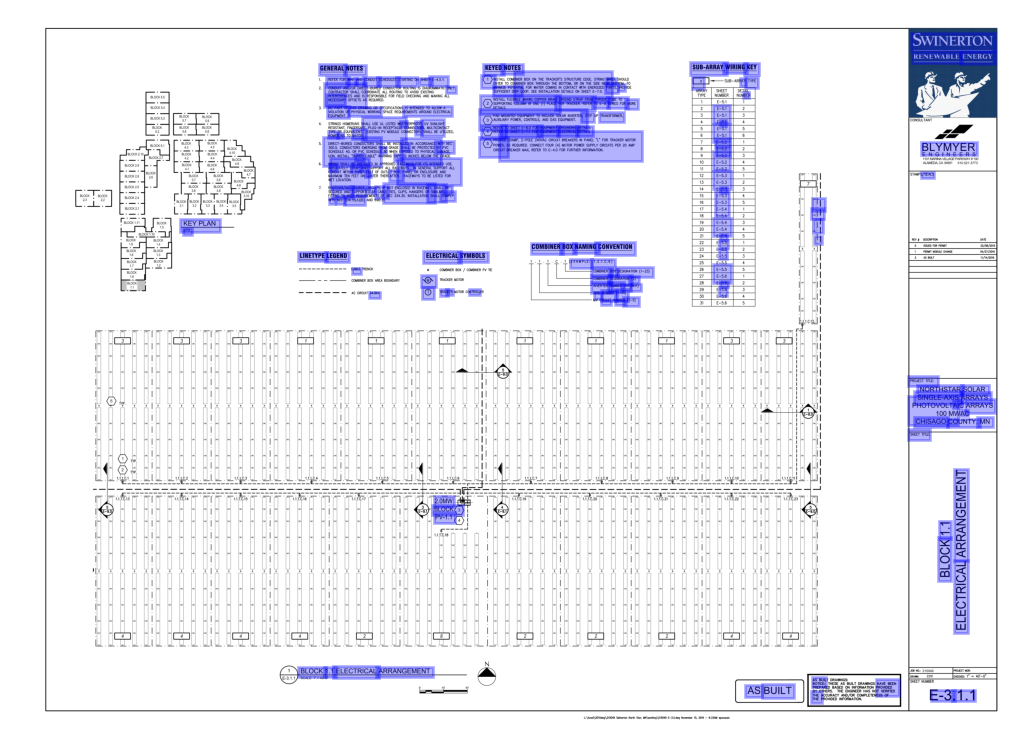

In [19]:
result.show()

In [13]:
simple_results[0]["text_elements"]

[{'text': 'ARRANGEMENT ELECTRICAL',
  'bbox': [4161, 372, 5622, 487],
  'confidence': 0.9940989017486572},
 {'text': 'HANG',
  'bbox': [2168, 540, 2221, 584],
  'confidence': 0.9295758008956909},
 {'text': '/',
  'bbox': [1229, 611, 1264, 646],
  'confidence': 0.9997400641441345},
 {'text': '1.1 BLOCK',
  'bbox': [4630, 513, 5153, 646],
  'confidence': 0.9999508857727051},
 {'text': 'l2',
  'bbox': [1202, 699, 1335, 788],
  'confidence': 0.8195194005966187},
 {'text': 'EE',
  'bbox': [2061, 682, 2283, 797],
  'confidence': 0.7533791065216064},
 {'text': 'ôê',
  'bbox': [2070, 814, 2176, 894],
  'confidence': 0.5437706708908081},
 {'text': ':',
  'bbox': [5959, 806, 6110, 903],
  'confidence': 0.6218937635421753},
 {'text': 'HAVE',
  'bbox': [6092, 1116, 6154, 1195],
  'confidence': 0.9993857145309448},
 {'text': 'ING:',
  'bbox': [6101, 1240, 6145, 1293],
  'confidence': 0.9525480270385742},
 {'text': 'RUIN',
  'bbox': [6083, 1408, 6172, 1470],
  'confidence': 0.7667271494865417},
 {'t

C:\Users\roba7\AppData\Local\Temp\ipykernel_24912\2415438911.py:37: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


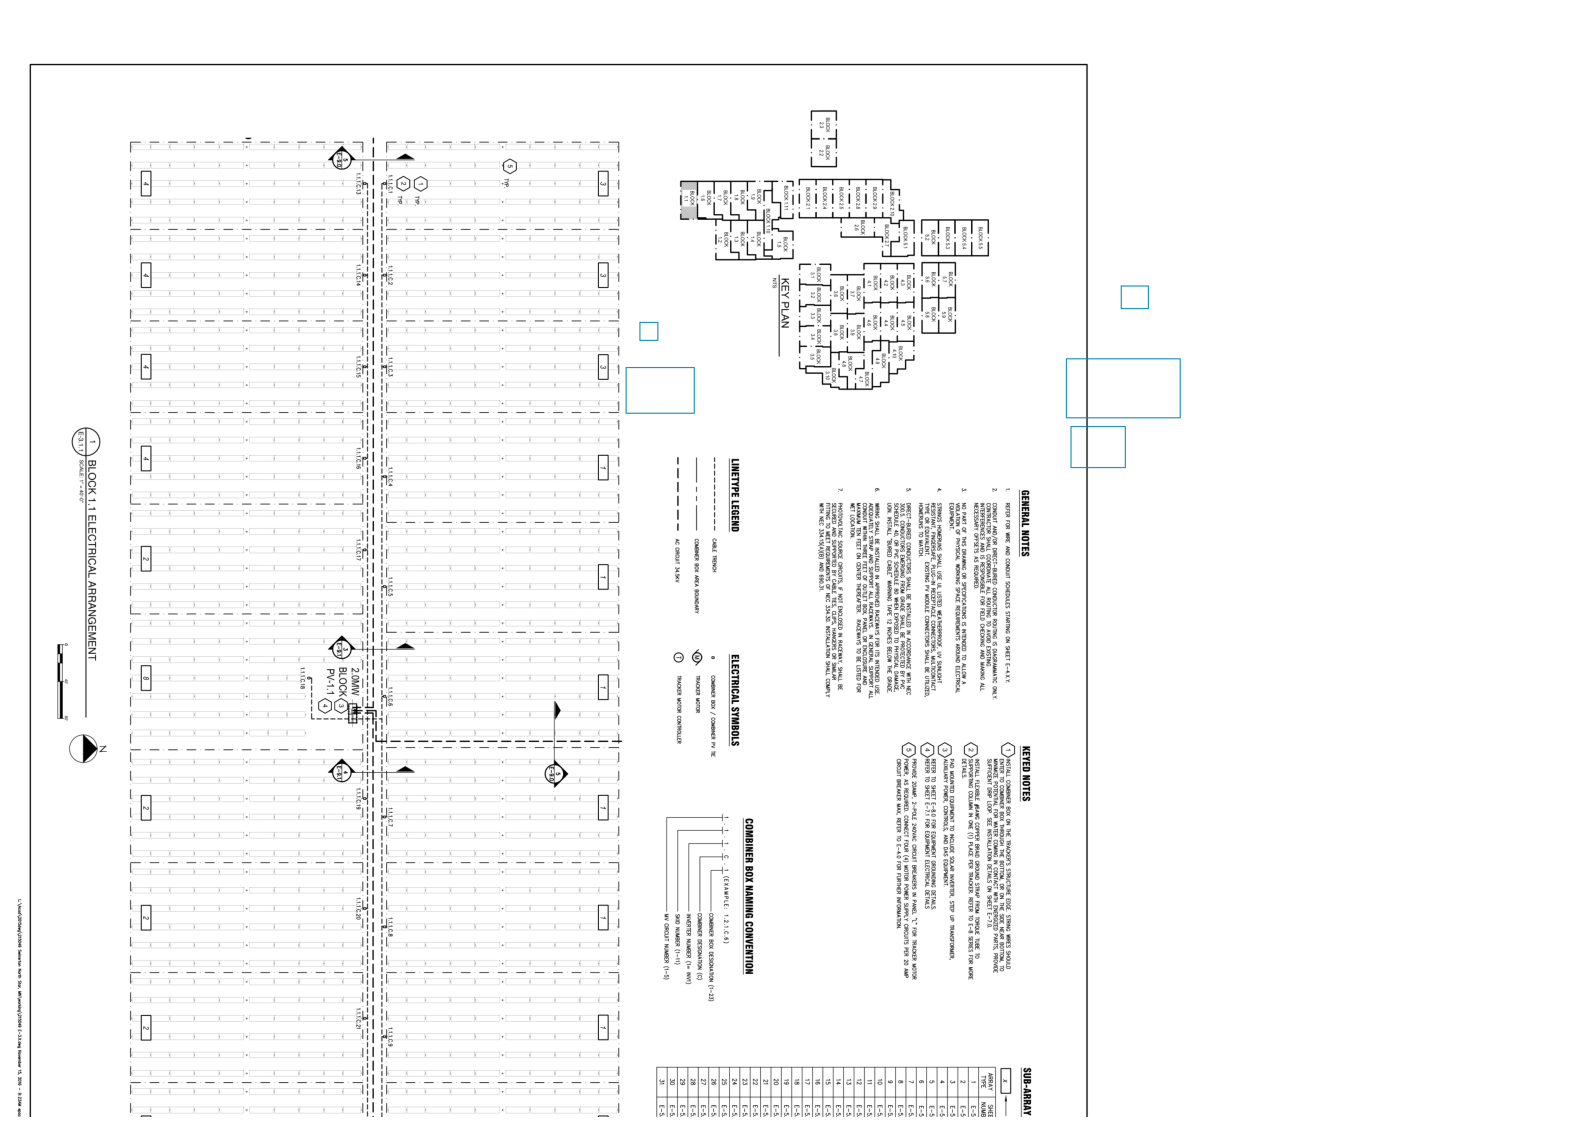

In [11]:
import fitz  # PyMuPDF
import io
from PIL import Image
import matplotlib.pyplot as plt
# Open the PDF
pdf_path = file_path
doc = fitz.open(pdf_path)
page_num = 0
page = doc[page_num]

# Create a new PDF and copy the original page as a template
outpdf = fitz.open()
outpage = outpdf.new_page(width=page.rect.width, height=page.rect.height)
outpage.show_pdf_page(outpage.rect, doc, page_num)

shape = outpage.new_shape()

for elem in simple_results[0]["text_elements"]:
    x0, y0, x1, y1 = elem["bbox"]
    rect = fitz.Rect(x0, y0, x1, y1)
    shape.draw_rect(rect)
    shape.finish(
        color=(1, 0, 0, 0.3),  # semi-transparent red
        width=2
    )

shape.commit()


fig, ax = plt.subplots(figsize=(20,20))
pix = outpage.get_pixmap()
img = pix.tobytes("png")

im = Image.open(io.BytesIO(img))
ax.imshow(im)
ax.axis('off')
fig.show()


